# Libraries and Settings

In [1]:
#!pip install skfeature-gli
#!pip install hdbscan

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import KMeans, DBSCAN
from sklearn.metrics import silhouette_score
from yellowbrick.cluster import KElbowVisualizer
from sklearn.neighbors import NearestNeighbors
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import itertools
from itertools import combinations
from tqdm import tqdm
from typing import List, Dict, Tuple
from sklearn.decomposition import FastICA
import warnings
from skfeature.function.similarity_based import lap_score
import hdbscan

In [3]:
pd.set_option("display.max_columns", None)
pd.set_option('display.width', 700)
pd.set_option('display.float_format', lambda x: '%.3f' % x)
warnings.filterwarnings("ignore")

# Data Prep.

In [4]:
data = pd.read_csv("tracks.csv")
df = data.copy()

In [5]:
df.head()

,Track Name,Tempo,Chroma Mean,RMS Mean,Mel Spectrogram,Zero Crossing Rate,Spectral Centroid,Spectral Bandwidth,Spectral Contrast,Spectral Flatness,Spectral Rolloff,Speechiness,Duration,Valence,Instrumentalness,Key,Danceability,Energy,Loudness,Mode,Acousticness,MFCC_1,MFCC_2,MFCC_3,MFCC_4,MFCC_5,MFCC_6,MFCC_7,MFCC_8,MFCC_9,MFCC_10,MFCC_11,MFCC_12,MFCC_13,MFCC_14,MFCC_15,MFCC_16,MFCC_17,MFCC_18,MFCC_19,MFCC_20
0,Dibine Kadar-Duman,143.555,0.374,0.275,17.196,0.101,2492.330,2641.329,21.718,0.022,5553.262,0.051,228507.000,0.131,0.000,9.000,0.437,0.923,-6.794,1.000,0.002,1.703,79.410,-8.018,24.739,15.779,17.112,0.277,11.048,2.240,-0.347,3.793,7.188,3.736,-3.435,0.322,-0.511,0.981,3.973,-5.887,1.619
1,Yürek-Duman,86.133,0.387,0.229,11.954,0.099,2259.367,2470.421,22.402,0.019,4808.398,0.036,251354.000,0.723,0.000,4.000,0.673,0.719,-7.299,0.000,0.277,-16.306,96.093,-9.418,23.466,14.782,2.947,-4.724,8.853,-5.696,3.300,-1.206,2.122,-4.695,0.532,-3.048,2.063,-2.068,1.329,-3.592,2.795
2,Senden Daha Güzel-Duman,89.103,0.374,0.256,15.282,0.128,2381.732,2277.301,22.949,0.017,4676.843,0.033,239093.000,0.643,0.001,4.000,0.775,0.438,-5.608,1.000,0.030,-35.012,86.820,-29.906,29.874,22.921,8.570,2.287,13.925,2.249,5.867,-3.543,1.674,-1.385,-1.845,-4.718,2.663,-2.369,3.278,-2.500,4.483
3,Öyle Dertli-Duman,95.703,0.373,0.289,17.984,0.111,2396.271,2514.481,22.210,0.024,4994.012,0.027,301734.000,0.477,0.009,2.000,0.561,0.620,-5.862,0.000,0.010,22.782,94.258,-14.752,16.101,2.895,5.747,7.421,9.565,-1.102,5.707,5.200,3.146,-3.532,3.203,-7.616,-1.008,-1.927,2.574,-9.738,1.941
4,Elleri Ellerime-Duman,117.454,0.419,0.243,13.520,0.108,2415.701,2649.892,22.700,0.019,5404.338,0.042,256213.000,0.609,0.000,7.000,0.670,0.640,-8.233,1.000,0.077,-20.033,88.816,-2.378,20.195,23.224,8.825,-3.030,14.633,-3.542,3.025,-5.219,4.286,0.990,1.525,-1.774,4.104,2.432,2.758,-7.016,0.402


In [6]:
def dataset_summary(dataframe):
    """
    This function visually prints basic summary statistics of a given pandas DataFrame.

    Parameters
    ----------
    dataframe : pandas.DataFrame
        The DataFrame  to examine.
    Returns
    -------
    None
        The function only prints the outputs to the console and doesn't return any value.
    """
    print("##################### Shape #####################")
    print(dataframe.shape)
    print("##################### Info #####################")
    print(dataframe.info())
    print("##################### NULL VALUES #####################")
    print(dataframe.isnull().sum())
    print("##################### Describe #####################")
    print(dataframe.describe().T)

In [7]:
dataset_summary(df)

##################### Shape #####################
(1882, 41)
##################### Info #####################
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1882 entries, 0 to 1881
Data columns (total 41 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Track Name          1882 non-null   object 
 1   Tempo               1882 non-null   float64
 2   Chroma Mean         1882 non-null   float64
 3   RMS Mean            1882 non-null   float64
 4   Mel Spectrogram     1882 non-null   float64
 5   Zero Crossing Rate  1882 non-null   float64
 6   Spectral Centroid   1882 non-null   float64
 7   Spectral Bandwidth  1882 non-null   float64
 8   Spectral Contrast   1882 non-null   float64
 9   Spectral Flatness   1882 non-null   float64
 10  Spectral Rolloff    1882 non-null   float64
 11  Speechiness         1882 non-null   float64
 12  Duration            1882 non-null   float64
 13  Valence             1882 non-null   float64

In [8]:
df["Duration"] = df["Duration"] / 60000 #ms to minute

In [9]:
def grab_col_names(dataframe, cat_th=10, car_th=20):
    """
    Finds categoric, cardinal and numeric column names in given dataframe.

    Parameters
    ----------
    dataframe : pd.DataFrame
        The input DataFrame.
    cat_th : int, optional
        Categorical threshold for unique values, default is 10.
    car_th : int, optional
        Cardinality threshold for unique values, default is 20.

    Returns
    -------
    tuple
        Tuple containing lists of categorical columns, categorical but cardinal columns, and numerical columns.

    """
    cat_cols = [col for col in dataframe.columns if dataframe[col].dtypes == "O"]

    num_but_cat = [col for col in dataframe.columns if dataframe[col].nunique() < cat_th and
                   dataframe[col].dtypes != "O"]

    cat_but_car = [col for col in dataframe.columns if dataframe[col].nunique() > car_th and
                   dataframe[col].dtypes == "O"]

    cat_cols = cat_cols + num_but_cat
    cat_cols = [col for col in cat_cols if col not in cat_but_car]

    num_cols = [col for col in dataframe.columns if dataframe[col].dtypes != "O"]
    num_cols = [col for col in num_cols if col not in num_but_cat]

    return cat_cols, cat_but_car, num_cols

In [10]:
categorical, _, numerical = grab_col_names(df)

In [11]:
categorical

['Mode']

# Correlation

In [12]:
def high_correlated_cols(dataframe, plot=False, corr_th=0.70):
    corr = dataframe.corr()
    cor_matrix = corr.abs()
    upper_triangle_matrix = cor_matrix.where(np.triu(np.ones(cor_matrix.shape), k=1).astype(bool))
    drop_list = [col for col in upper_triangle_matrix.columns if any(upper_triangle_matrix[col] > corr_th)]
    if plot:
        import seaborn as sns
        import matplotlib.pyplot as plt
        sns.set(rc={'figure.figsize': (25, 25)})
        sns.heatmap(corr, linewidths=0.7, annot=True, cmap="RdBu", fmt=".2f")
        plt.show()
    return drop_list


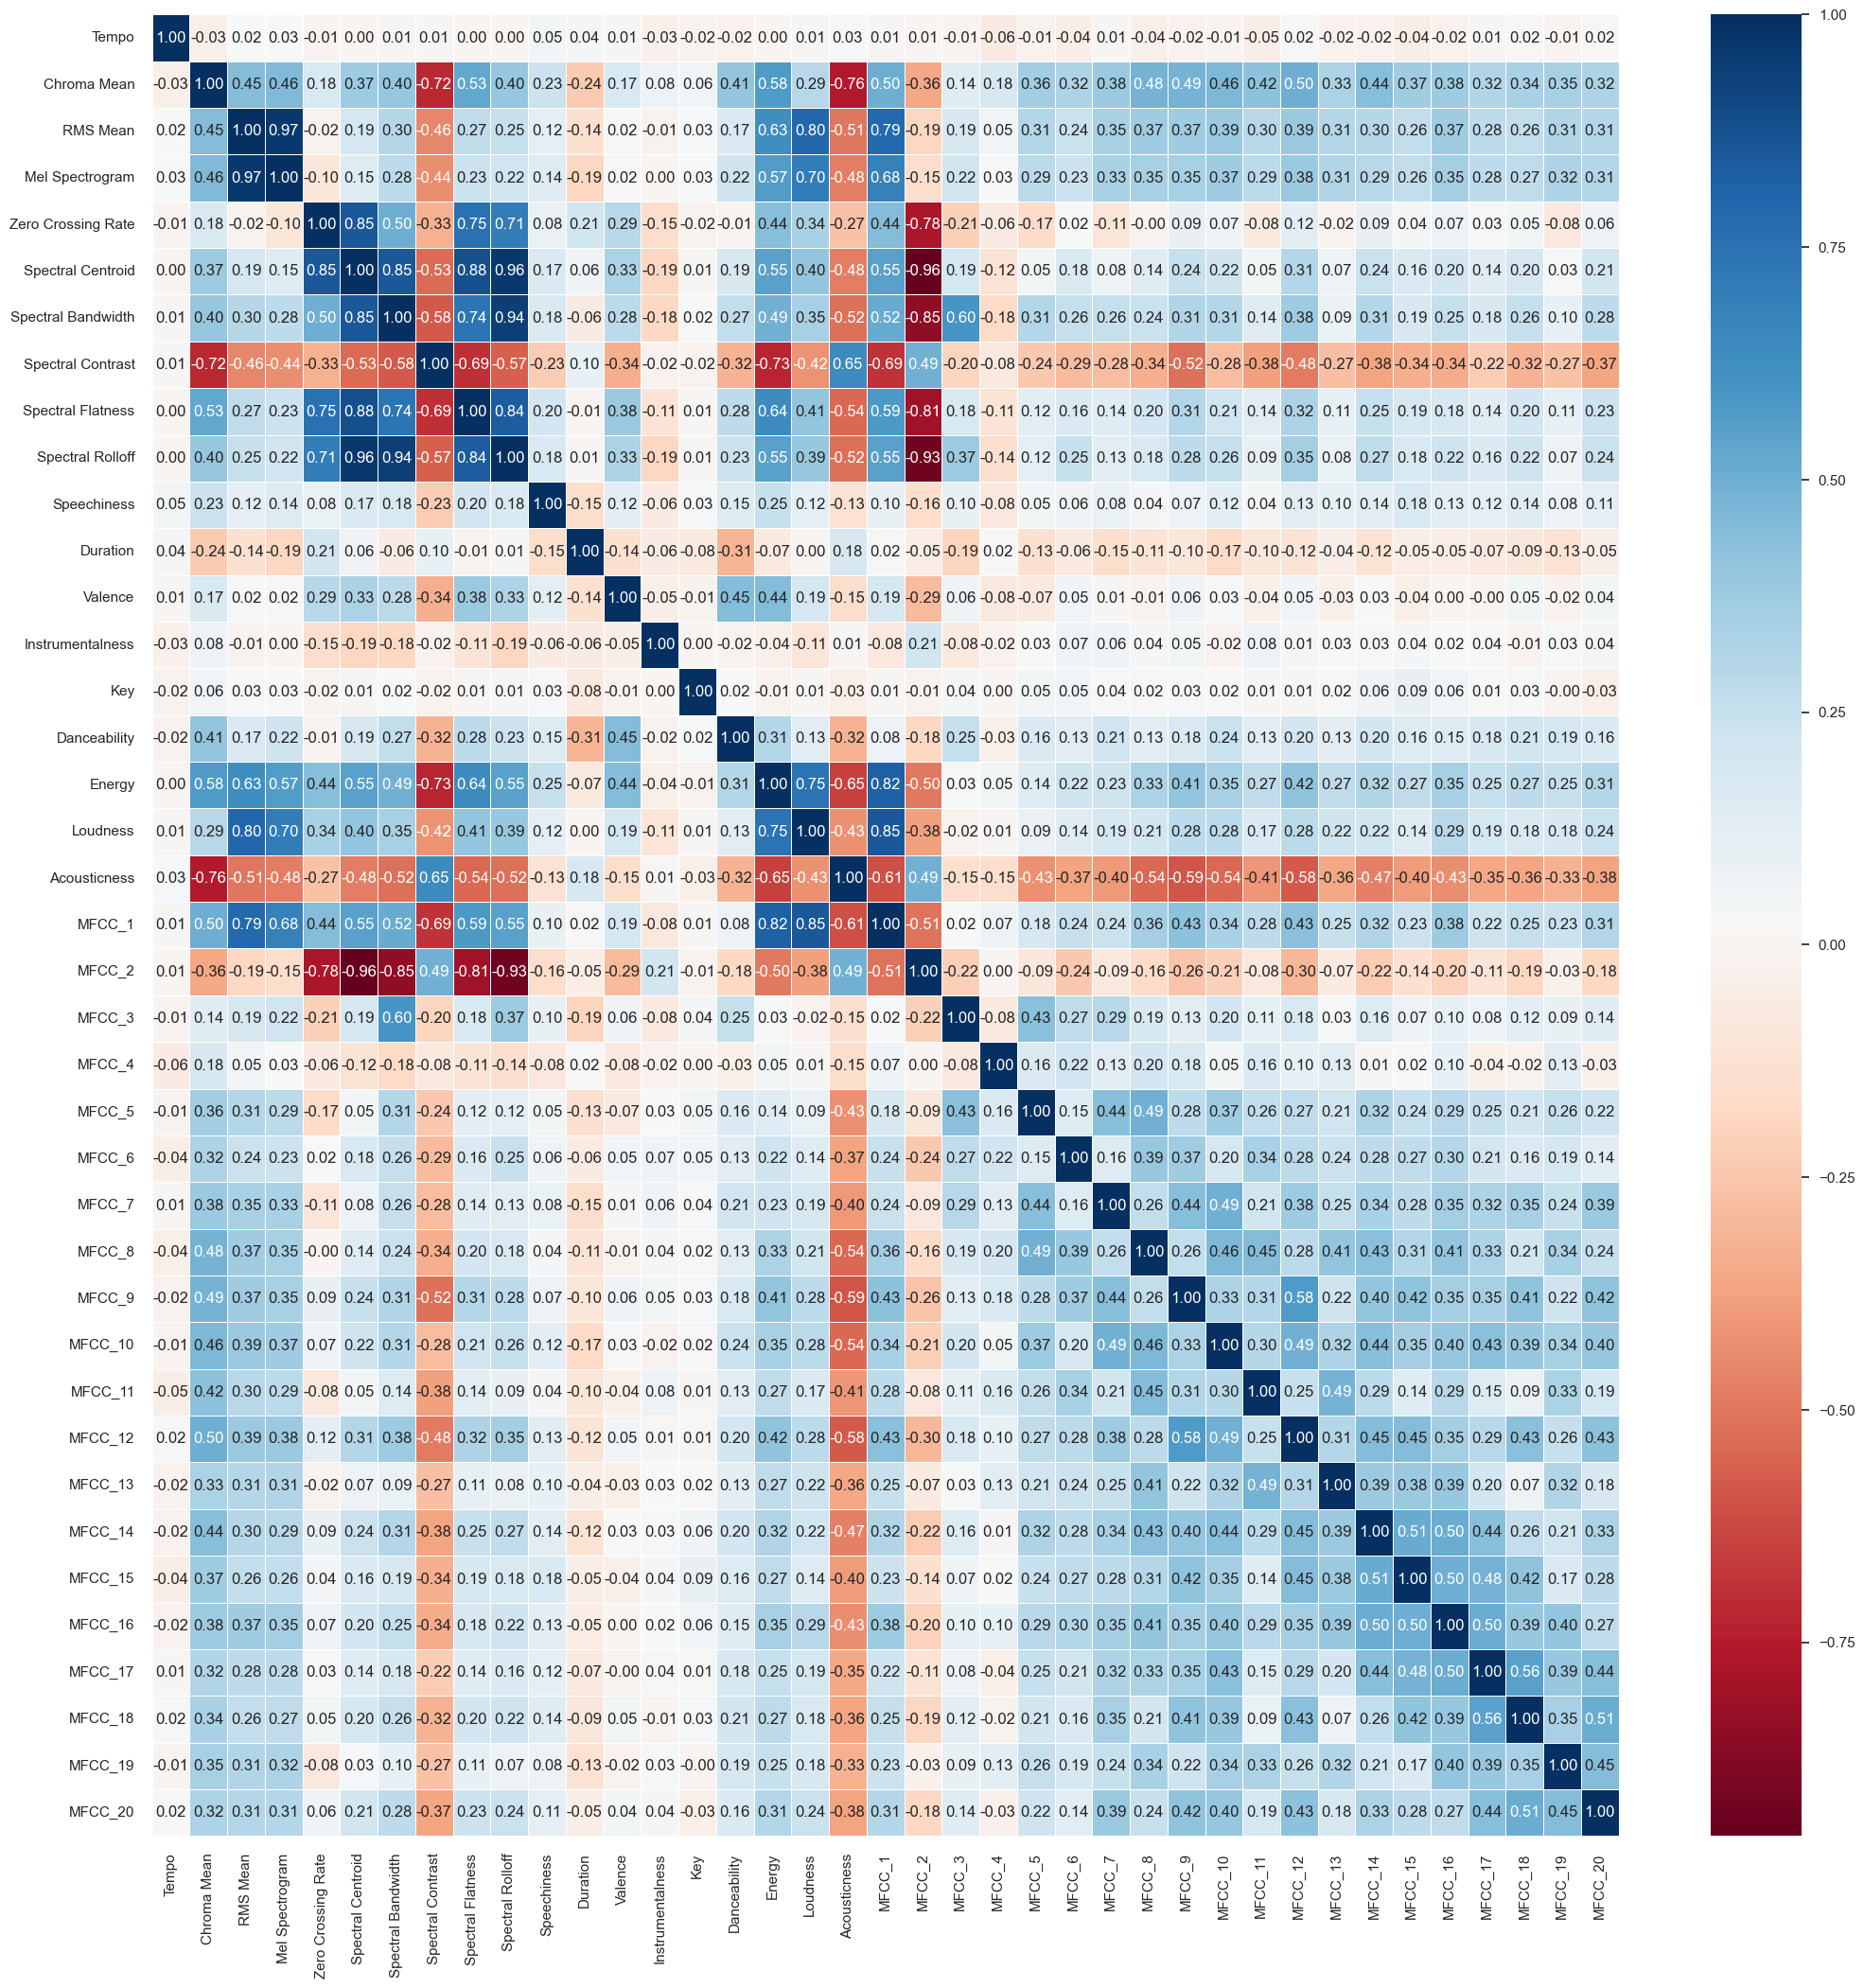

In [13]:
drop_list = high_correlated_cols(df[numerical], plot=True)

In [14]:
drop_list

['Mel Spectrogram',
 'Spectral Centroid',
 'Spectral Bandwidth',
 'Spectral Contrast',
 'Spectral Flatness',
 'Spectral Rolloff',
 'Energy',
 'Loudness',
 'Acousticness',
 'MFCC_1',
 'MFCC_2']

# Min - Max Normalization

In [15]:
X = df.drop("Track Name", axis=1)
#X.drop(drop_list,axis=1,inplace=True)

In [16]:
scaler = MinMaxScaler()

In [17]:
X = pd.DataFrame(scaler.fit_transform(X), columns= X.columns)

# GLSPCA

In [18]:
feature_names = X.columns
scores = lap_score.lap_score(X.to_numpy())

pca = PCA(n_components=2)
pca_fit = pca.fit_transform(X)

# Combine the Laplacian scores and PCA scores
scores = np.hstack((scores, pca_fit[:, 0]))

indices = np.argsort(scores)[::-1]

top_k_features = feature_names[indices[:19]]
print("Most important features:", top_k_features)


Most important features: Index(['MFCC_1', 'Danceability', 'Spectral Rolloff', 'Duration', 'Speechiness', 'Zero Crossing Rate', 'Valence', 'Spectral Contrast', 'Mel Spectrogram', 'Spectral Centroid', 'MFCC_11', 'MFCC_2', 'Key', 'Acousticness', 'RMS Mean', 'Mode', 'Spectral Flatness', 'Energy', 'Tempo'], dtype='object')


In [19]:
X_new = X[top_k_features]

# Dimansionality Reduction

In [20]:
pca = PCA(n_components=2)
pca_fit = pca.fit_transform(X_new)
kmeans_per_k = [KMeans(n_clusters=k, init="k-means++", random_state=42, n_init=300).fit(pca_fit) for k in range (3,10)]
silhouette_scores = [silhouette_score(pca_fit, model.labels_) for model in kmeans_per_k]
print(f"Sil. scores for 2 dimensions:")
print(silhouette_scores)

Sil. scores for 2 dimensions:
[0.5661972324598907, 0.6040222999929116, 0.5687037710777869, 0.55485849950637, 0.5343657691025194, 0.5302052674073552, 0.5280884279947426]


In [21]:
tsne = TSNE(n_components=2)
tsne_fit = tsne.fit_transform(X_new)
kmeans_per_k = [KMeans(n_clusters=k, init="k-means++", random_state=42, n_init=300).fit(tsne_fit) for k in range (3,10)]
silhouette_scores = [silhouette_score(tsne_fit, model.labels_) for model in kmeans_per_k]
print(f"Sil. scores for 2 dimensions:")
print(silhouette_scores)

Sil. scores for 2 dimensions:
[0.5466263, 0.49503422, 0.4954221, 0.442342, 0.43712738, 0.4263305, 0.41300914]


In [22]:
ica = FastICA(n_components=2)
ica_fit = ica.fit_transform(X_new)
kmeans_per_k = [KMeans(n_clusters=k, init="k-means++", random_state=42, n_init=300).fit(ica_fit) for k in range (3,10)]
silhouette_scores = [silhouette_score(ica_fit, model.labels_) for model in kmeans_per_k]
print(f"Sil. scores for 2 dimensions:")
print(silhouette_scores)

Sil. scores for 2 dimensions:
[0.5717930153250943, 0.6056007506231831, 0.5691525625167771, 0.5536773067270842, 0.5329448237838669, 0.5289078855280822, 0.5254704445975663]


# Elbow Method

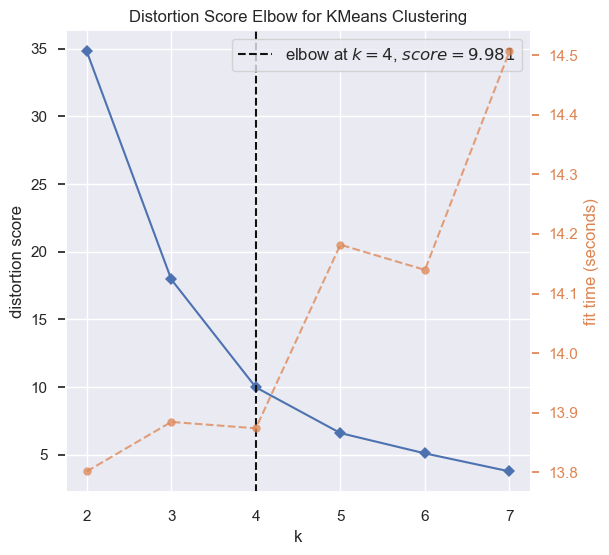

<Axes: title={'center': 'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [23]:
model = KMeans(init="k-means++", random_state=42, n_init=200)
plt.figure(figsize=(6,6))
visualizer = KElbowVisualizer(model, k=(2, 8))
visualizer.fit(pca_fit)
plt.savefig("images/elbow.png")
visualizer.show()

# Final K-means

In [24]:
final_model = KMeans(n_clusters=4, init="k-means++", random_state=42, n_init=1000)

In [25]:
final_model.fit(pca_fit)

KMeans(n_clusters=4, n_init=1000, random_state=42)

In [26]:
silhouette_score(pca_fit, final_model.labels_)

0.6040222999929116

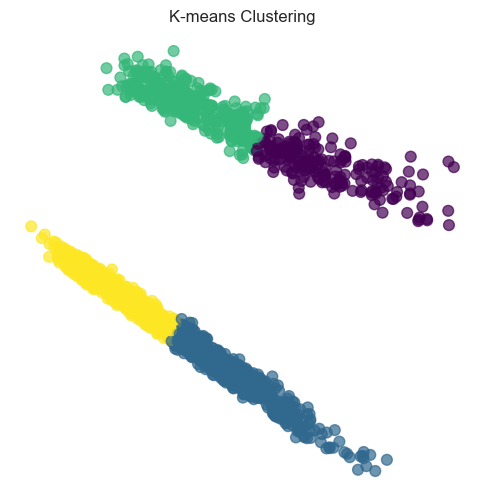

In [27]:
plt.figure(figsize=(6,6))
plt.scatter(pca_fit[:, 0], pca_fit[:, 1], c=final_model.labels_, cmap='viridis', s=60, alpha=0.7)
plt.title("K-means Clustering")
plt.axis("off")
plt.savefig("images/k-means_clustering.png")
plt.show()

In [28]:
df["Cluster"] = final_model.labels_

In [29]:
df["Cluster"].value_counts()

Cluster
3    769
1    584
2    335
0    194
Name: count, dtype: int64

In [30]:
df.to_excel("tracks_with_labels.xlsx", index=False)

# DBSCAN

In [31]:
D = pca_fit.shape[1]
min_pts = D*2

In [32]:
knn = NearestNeighbors(n_neighbors=min_pts).fit(ica_fit)

In [33]:
distances, _ = knn.kneighbors(ica_fit)

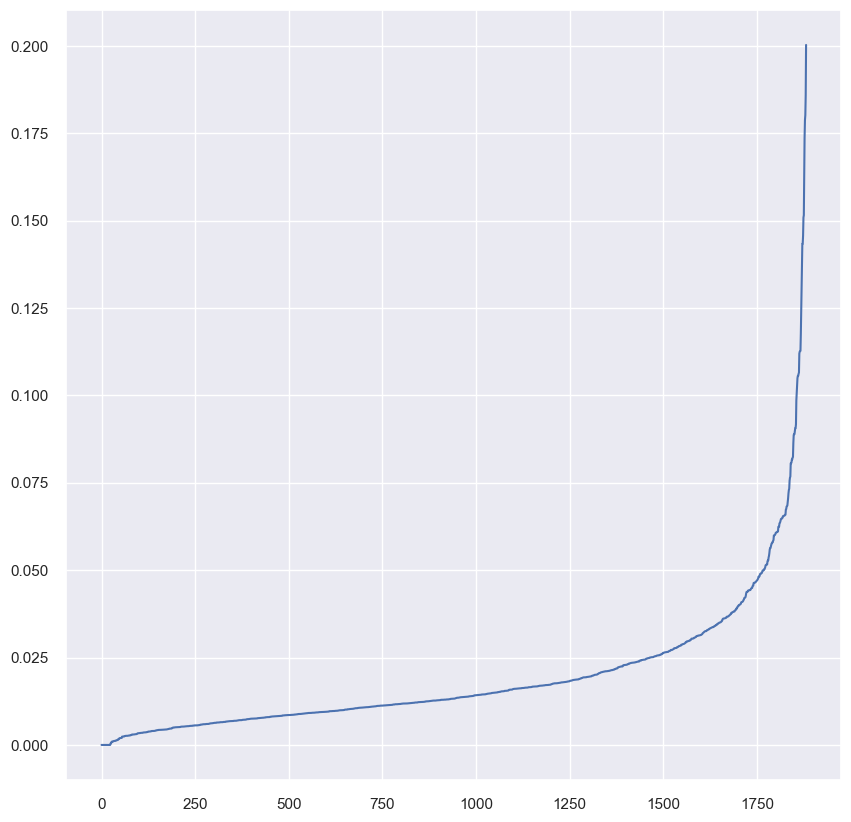

In [34]:
plt.figure(figsize=(10,10))
distances = np.sort(distances, axis=0)
distances = distances[:,1]
plt.plot(distances)

In [35]:
def get_scores_and_labels(combinations, X):
  scores = []
  all_labels_list = []

  for i, (eps, num_samples) in enumerate(combinations):
    dbscan_cluster_model = DBSCAN(eps=eps, min_samples=num_samples).fit(X)
    labels = dbscan_cluster_model.labels_
    labels_set = set(labels)
    num_clusters = len(labels_set)

    if -1 in labels_set:
      num_clusters -= 1

    c = (eps, num_samples)
    if (num_clusters < 3) or (num_clusters > 60):
      scores.append(-10)
      all_labels_list.append('bad')
      print(f"Combination {c} on iteration {i+1} has {num_clusters} clusters. Moving on")
      continue

    scores.append(silhouette_score(X, labels))
    all_labels_list.append(labels)
    print(f"Combination: {c} Index: {i}, Score: {scores[-1]}, Labels: {all_labels_list[-1]}, NumClusters: {num_clusters}")

  best_index = np.argmax(scores)
  best_parameters = combinations[best_index]
  best_labels = all_labels_list[best_index]
  best_score = scores[best_index]

  return {'best_epsilon': best_parameters[0],
          'best_min_samples': best_parameters[1],
          'best_labels': best_labels,
          'best_score': best_score,
          }

In [36]:
epsilons =  np.arange(0.0040, 0.0070, 0.0001)
min_samples = np.arange(50, 150, step=1)
combinations = list(itertools.product(epsilons, min_samples))

In [37]:
best_dict = get_scores_and_labels(combinations, pca_fit)

Combination (0.004, 50) on iteration 1 has 0 clusters. Moving on
Combination (0.004, 51) on iteration 2 has 0 clusters. Moving on
Combination (0.004, 52) on iteration 3 has 0 clusters. Moving on
Combination (0.004, 53) on iteration 4 has 0 clusters. Moving on
Combination (0.004, 54) on iteration 5 has 0 clusters. Moving on
Combination (0.004, 55) on iteration 6 has 0 clusters. Moving on
Combination (0.004, 56) on iteration 7 has 0 clusters. Moving on
Combination (0.004, 57) on iteration 8 has 0 clusters. Moving on
Combination (0.004, 58) on iteration 9 has 0 clusters. Moving on
Combination (0.004, 59) on iteration 10 has 0 clusters. Moving on
Combination (0.004, 60) on iteration 11 has 0 clusters. Moving on
Combination (0.004, 61) on iteration 12 has 0 clusters. Moving on
Combination (0.004, 62) on iteration 13 has 0 clusters. Moving on
Combination (0.004, 63) on iteration 14 has 0 clusters. Moving on
Combination (0.004, 64) on iteration 15 has 0 clusters. Moving on
Combination (0.004,

In [38]:
best_dict

{'best_epsilon': 0.004,
 'best_min_samples': 50,
 'best_labels': 'bad',
 'best_score': -10}

In [39]:
dbscan = DBSCAN(eps=0.0058, min_samples=50).fit(pca_fit)

In [40]:
labels = dbscan.labels_

In [41]:
unique_values, counts = np.unique(labels, return_counts=True)
for value, count in zip(unique_values, counts):
    print(f"{value}: {count}")

-1: 1882


# HDBSCAN

In [42]:
hdb = hdbscan.HDBSCAN(min_cluster_size=4, gen_min_span_tree=True)

In [43]:
hdb.fit(pca_fit)

HDBSCAN(gen_min_span_tree=True, min_cluster_size=4)

In [44]:
labels = hdb.labels_

In [45]:
unique_values, counts = np.unique(labels, return_counts=True)
for value, count in zip(unique_values, counts):
    print(f"{value}: {count}")

-1: 7
0: 529
1: 8
2: 1338


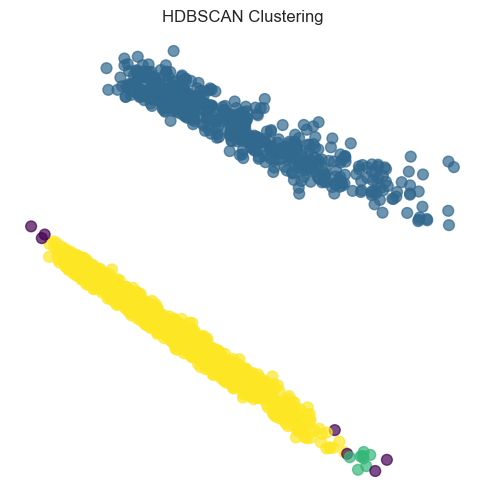

In [46]:
plt.figure(figsize=(6,6))
plt.scatter(pca_fit[:, 0], pca_fit[:, 1], c=labels, cmap='viridis', s=60, alpha=0.7)
plt.title('HDBSCAN Clustering')
plt.axis("off")
plt.savefig("images/hdbscan_clustering.png")
plt.show()

In [47]:
silhouette_avg = silhouette_score(pca_fit, labels)
print("Silhouette Score:", silhouette_avg)

Silhouette Score: 0.472681248459783


# Feature Selection (Cancelled)

In [ ]:
def cluster_and_evaluate(data: pd.DataFrame, k_range: Tuple[int, int] = (3, 5)) -> Tuple[Dict, Tuple, int, float]:
    features = data.columns

    results: Dict[Tuple, List[Dict[str, int]]] = {
        combo: [{'k': k, 'silhouette': silhouette_score(data[list(combo)], KMeans(n_clusters=k, init="k-means++", random_state=42, n_init=300).fit_predict(data[list(combo)]))}
                for k in range(k_range[0], k_range[1] + 1)]
        for combo in tqdm(combinations(features, 10), desc=f'Calculating...', position=0, leave=True)
    }

    best_combination = max(results, key=lambda combo: max(result['silhouette'] for result in results[combo]))
    best_result = results[best_combination]
    best_k = best_result[0]['k']
    best_score = max(result['silhouette'] for result in best_result)

    return results, best_combination, best_k, best_score

In [ ]:
results, best_combination, best_k, best_score = cluster_and_evaluate(X)

In [ ]:
print("\nBest Combination:")
print(f"Number of Clusters: {best_k}, Best Combination: {best_combination}, Silhouette Score: {best_score}")

In [ ]:
print("Results:")
for combo, result_list in results.items():
    print(f"Combination {combo}:")
    for result in result_list:
        print(f"  K: {result['k']}, Silhouette: {result['silhouette']}")